Sam Schmidt and Chris Stubbs May 30, 2018

Test reading in multiple Hypersuprime-cam (HSC) files, try to make some color-color diagrams, eventually try to look at the stellar locus.

HSC data available at /datasets/hsc/repo/rerun/DM-13666/* where * = UDEEP, DEEP, or WIDE
see some documentation at 
https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing

We are going to use Pandas dataframes, which are not included in the LSP builds.  Pandas will also need pyTables  To install pandas:

pip install --user pandas

To install pyTables:

pip install --user tables


In [2]:
import lsst.daf.persistence as daf_persistence
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 10)
import pandas as pd
import glob

In [3]:
depth = 'DEEP' #use the DEEP catalog, got this file path from another notebook
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


An example showing the file paths for tract=10054 patch='0,0' for all five bands (note that tracts are stored as integers, but patches are strings.

In [4]:
bandlist = ['HSC-G','HSC-R','HSC-I','HSC-Z','HSC-Y'] #grab the main broad bands
bandpaths = []
for band in bandlist:
    infile = glob.glob('/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/%s/10054/0,0/forced_src*'%(band))
    print (infile)
    bandpaths.append(infile)

['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/0,0/forced_src-HSC-G-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-R/10054/0,0/forced_src-HSC-R-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-I/10054/0,0/forced_src-HSC-I-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-Z/10054/0,0/forced_src-HSC-Z-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-Y/10054/0,0/forced_src-HSC-Y-10054-0,0.fits']


For now, let's limit ourselves to one tract, we'll use 10054. We find all of the patches in this tract.  It turns out Y has the fewest number of processed patches, I'll just use that for now.  

TODO: Need to fix this to make a robust list of the patches that exist in *all* of the filters!

In [5]:
tract = 10054
band = 'HSC-Y'

In [6]:
files = glob.glob('/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/%s/10054/*/'%(band))
patches = []
for x in files:
    patches.append(x[-4:-1])
print (patches)
#patches = ['7,0']

['3,0', '0,0', '2,0', '3,1', '1,0', '2,1', '1,1', '2,2', '0,1', '1,2', '0,2']


A test of selection flags.  We copied list of "good" flags from a previous notebook by Keith Bechtol.  These cells show an example of the source, reference, and calibration data files, which are loaded by defining their tract, patch, and filter.

In [7]:
patch = '0,0'
sources = butler.get('deepCoadd_forced_src', tract=tract, patch=patch, filter=band)
src_refs = butler.get('deepCoadd_ref',tract=tract,patch=patch,filter=band)
src_calib = butler.get('deepCoadd_calexp_calib',tract=tract,patch=patch,filter=band)
selection_catalog = src_refs['detect_isPrimary'] \
    & ~sources['base_SdssCentroid_flag'] \
    & ~sources['base_PixelFlags_flag_interpolated'] \
    & ~sources['base_PixelFlags_flag_saturated'] \
    & ~sources['base_PsfFlux_flag'] \
    & ~sources['modelfit_CModel_flag'] 
        

In [8]:
print (selection_catalog)
print (sum(selection_catalog))

[False False False ... False False False]
2340


In [9]:
#patches = ('0,0','3,0') #demo shorter list of two patches for quick tests of things 

In [10]:
flagfilter = 'HSC-I' #the filter in which the "good" flags are set
df_hsc = 'Null'
df_patchtmp = 'Null'
for band in bandlist:
    print (tract,patch)
    df_patch = 'Null'
    for patch in patches:
        psfname = "%s_psf"%(band[4])
        cmname = "%s_cm"%(band[4])
        sources = butler.get('deepCoadd_forced_src', tract=tract, patch=patch, filter=band)
        src_refs = butler.get('deepCoadd_ref',tract=tract,patch=patch,filter=band)
        src_calib = butler.get('deepCoadd_calexp_calib',tract=tract,patch=patch,filter=band)
        src_calib.setThrowOnNegativeFlux(False) #this is necessary to not have the getMagnitude panic when NaNs are returned
        flagrefs = butler.get('deepCoadd_ref',tract=tract,patch=patch,filter=flagfilter)
        flag_sources = butler.get('deepCoadd_forced_src', tract=tract, patch=patch, filter=flagfilter)
        selection_catalog = flagrefs['detect_isPrimary'] \
            & ~flag_sources['base_SdssCentroid_flag'] \
            & ~flag_sources['base_PixelFlags_flag_interpolated'] \
            & ~flag_sources['base_PixelFlags_flag_saturated'] \
            & ~flag_sources['base_PsfFlux_flag'] \
            & ~flag_sources['modelfit_CModel_flag'] 
        print (sum(selection_catalog))
        psf_mag_tup = src_calib.getMagnitude(sources['base_PsfFlux_flux'],sources['base_PsfFlux_fluxSigma'])
        cmodel_tup =  src_calib.getMagnitude(sources['modelfit_CModel_flux'],sources['modelfit_CModel_fluxSigma'])
        psfmag = psf_mag_tup[0]
        psfmagerr = psf_mag_tup[1]
        cmodel = cmodel_tup[0]
        cmodelerr = cmodel_tup[1]
        if band == flagfilter: #only add the extended flag for the reference filter!
            extend = sources.get('base_ClassificationExtendedness_value')[selection_catalog]
            data = {'%s_psf'%(band[4]): psfmag[selection_catalog], '%s_psferr'%(band[4]): psfmagerr[selection_catalog], 
            '%s_cm'%(band[4]): cmodel[selection_catalog], '%s_cmerr'%(band[4]):cmodelerr[selection_catalog], 'extended': extend}
        else:
            data = {'%s_psf'%(band[4]): psfmag[selection_catalog], '%s_psferr'%(band[4]): psfmagerr[selection_catalog], 
            '%s_cm'%(band[4]): cmodel[selection_catalog], '%s_cmerr'%(band[4]):cmodelerr[selection_catalog]}
        if df_patch is 'Null':            
            df_patch = pd.DataFrame(data=data)
            print (df_patch.shape)
        else:
            df_patchtmp = pd.DataFrame(data=data)
            df_patch = pd.concat([df_patch,df_patchtmp])  #concatenate each patch to end of file
            del df_patchtmp
            print (df_patch.shape)
    if df_hsc is 'Null':
        df_hsc = df_patch
    else: 
        df_hsc = pd.concat([df_hsc, df_patch], axis=1) #concatenate band columns into single pandas dataframe
        del df_patch

10054 0,0
6404
(6404, 4)
3241
(9645, 4)
7103
(16748, 4)
13020
(29768, 4)
7142
(36910, 4)
14282
(51192, 4)
14060
(65252, 4)
12567
(77819, 4)
7366
(85185, 4)
13646
(98831, 4)
6783
(105614, 4)
10054 0,2
6404
(6404, 4)
3241
(9645, 4)
7103
(16748, 4)
13020
(29768, 4)
7142
(36910, 4)
14282
(51192, 4)
14060
(65252, 4)
12567
(77819, 4)
7366
(85185, 4)
13646
(98831, 4)
6783
(105614, 4)
10054 0,2
6404
(6404, 5)
3241
(9645, 5)
7103
(16748, 5)
13020
(29768, 5)
7142
(36910, 5)
14282
(51192, 5)
14060
(65252, 5)
12567
(77819, 5)
7366
(85185, 5)
13646
(98831, 5)
6783
(105614, 5)
10054 0,2
6404
(6404, 4)
3241
(9645, 4)
7103
(16748, 4)
13020
(29768, 4)
7142
(36910, 4)
14282
(51192, 4)
14060
(65252, 4)
12567
(77819, 4)
7366
(85185, 4)
13646
(98831, 4)
6783
(105614, 4)
10054 0,2
6404
(6404, 4)
3241
(9645, 4)
7103
(16748, 4)
13020
(29768, 4)
7142
(36910, 4)
14282
(51192, 4)
14060
(65252, 4)
12567
(77819, 4)
7366
(85185, 4)
13646
(98831, 4)
6783
(105614, 4)


Because this takes quite long to run, let's write this data out to an hdf5 file. comment out so it doesn't write out every time, uncomment to create the file, you can read the data in with the commented line in the next cell.

In [26]:
#outfile_hsc_color = "outfile_10054_grizy.h5"
#df_hsc.to_hdf(outfile_hsc_color, 'df_hsc')

You can read this in the hdf5 file later with the below line:

In [12]:
#df_hsc = pd.read_hdf('outfile_10054_grizy.h5', 'df_hsc')


In [13]:
#help (src_calib)
df_hsc.head()

,G_cm,G_cmerr,G_psf,G_psferr,R_cm,R_cmerr,R_psf,R_psferr,I_cm,I_cmerr,...,I_psferr,extended,Z_cm,Z_cmerr,Z_psf,Z_psferr,Y_cm,Y_cmerr,Y_psf,Y_psferr
0,30.064821,6.744540,27.877673,0.841859,26.692917,0.189936,26.690253,0.183695,25.993736,0.115199,...,0.113273,1.0,25.736775,0.165605,25.773944,0.166027,25.495492,0.732214,25.665042,0.819238
1,26.756039,0.371128,26.973090,0.373494,26.253820,0.157581,26.491903,0.160119,25.527403,0.090158,...,0.092592,1.0,25.713036,0.163483,25.935279,0.165364,27.660562,4.870747,28.099225,6.166926
2,25.891708,0.154158,25.945792,0.141629,25.614567,0.105928,25.816720,0.104505,24.919941,0.062771,...,0.063058,1.0,24.286989,0.056791,24.476520,0.057045,NaN,NaN,NaN,NaN
3,29.314471,4.471010,28.375605,1.330525,26.335085,0.198049,26.779034,0.211313,25.348404,0.111475,...,0.116966,1.0,24.981243,0.121448,25.434412,0.135064,NaN,NaN,NaN,NaN
4,27.121930,0.588344,27.145535,0.520054,25.827951,0.131627,26.060457,0.131305,25.656838,0.125782,...,0.125870,1.0,25.201802,0.109871,25.373514,0.111410,26.056207,1.575060,25.951817,1.272116


In [14]:
df_hsc.tail()

,G_cm,G_cmerr,G_psf,G_psferr,R_cm,R_cmerr,R_psf,R_psferr,I_cm,I_cmerr,...,I_psferr,extended,Z_cm,Z_cmerr,Z_psf,Z_psferr,Y_cm,Y_cmerr,Y_psf,Y_psferr
6778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.877210,0.674560,...,0.709554,1.0,33.502410,182.421932,33.694772,203.739551,24.687153,0.265200,24.742725,0.266294
6779,26.314524,0.259299,26.925411,0.302951,28.289033,1.603815,30.796843,7.940366,26.484533,0.380937,...,0.380763,1.0,27.609063,1.580239,29.637903,5.121901,23.428802,0.185735,24.165010,0.198747
6780,27.095084,0.394901,27.220943,0.411294,27.292073,0.338472,27.349053,0.345381,27.286352,0.440080,...,0.450607,1.0,26.663675,0.382863,26.667624,0.371238,27.890781,7.182251,26.712824,2.172613
6781,NaN,NaN,NaN,NaN,29.460536,3.078424,29.346855,2.250125,27.050749,0.459134,...,0.395063,1.0,26.454504,0.387127,26.761488,0.428932,24.496423,0.499033,24.583007,0.467300
6782,NaN,NaN,NaN,NaN,25.887195,0.441657,31.404930,14.802045,24.200611,0.123978,...,0.215733,1.0,24.673130,0.300300,28.878122,3.176679,23.221396,0.519907,26.535439,2.836844


plot the mag vs error for R-band to make sure that looks sensible

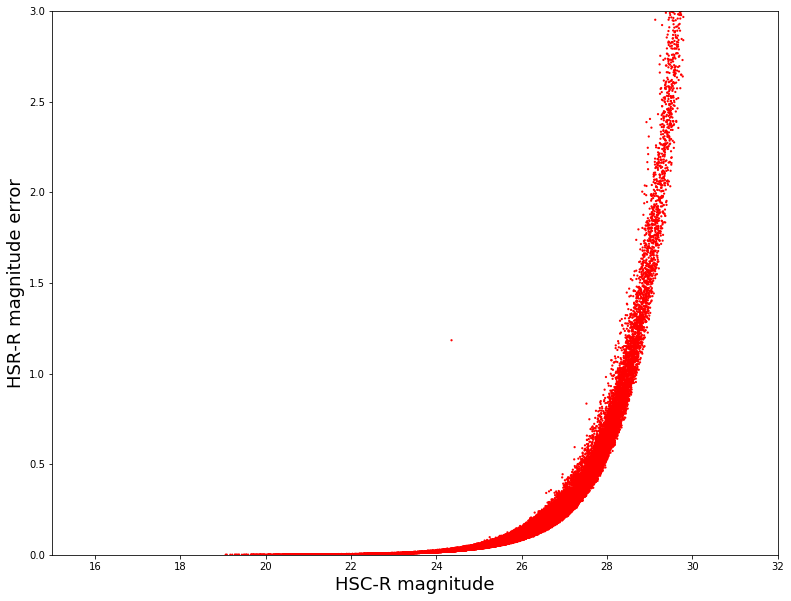

In [15]:
plt.scatter(df_hsc['R_psf'],df_hsc['R_psferr'],s=5,c='r',edgecolor='None')
plt.xlim([15,32])
plt.ylim([0,3])
plt.xlabel("HSC-R magnitude",fontsize=18)
plt.ylabel("HSR-R magnitude error",fontsize=18)

Create g-r  (PSF) colors for all objects, then make a mask for objects with small i-band error and that are listed as stars (extended==0 is stars extended == 1 is galaxies)

In [16]:
gr = df_hsc['G_psf'] - df_hsc['R_psf']
ri = df_hsc['R_psf'] - df_hsc['I_psf']
mask = np.logical_and(df_hsc['I_psferr']<.1, df_hsc['extended']<0.2)
grcut = gr[mask]
ricut = ri[mask]

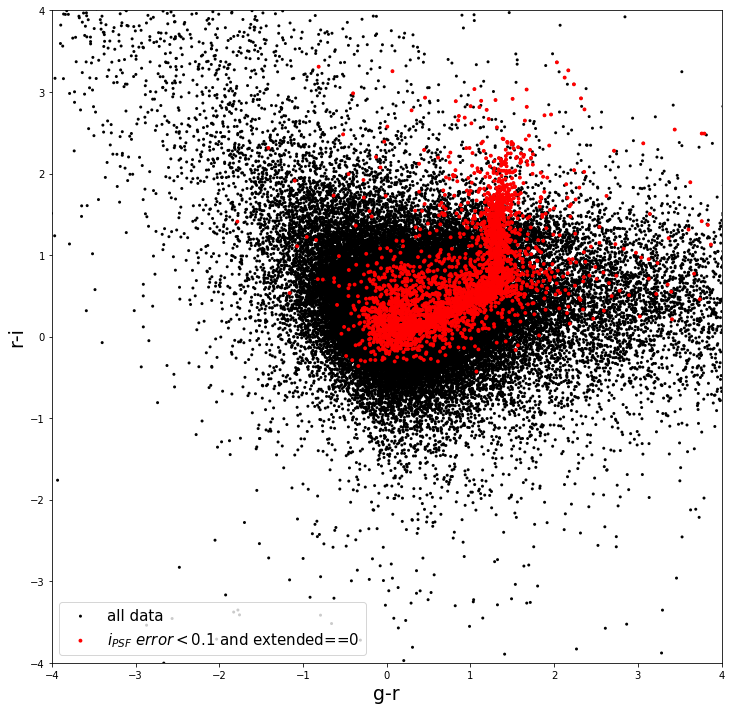

In [17]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.scatter(gr,ri,marker='o',s=9,c='k',edgecolor='none',label='all data')
plt.scatter(grcut,ricut,marker='o',s=15,c='r',edgecolor='none',label='$i_{PSF}\ error<0.1$ and extended==0')
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend(loc='lower left',fontsize=15)

Now make g-r and r-i for cmodel mags rather than PSF mags and compare to the above, though also including a more stringent magnitude error cut

In [18]:
grmod = df_hsc['G_cm'] - df_hsc['R_cm']
rimod = df_hsc['R_cm'] - df_hsc['I_cm']
izmod = df_hsc['I_cm'] - df_hsc['Z_cm']
maskmod = np.logical_and(df_hsc['I_cmerr']<.01, df_hsc['extended']<0.2)
trimdf = df_hsc[maskmod]
grmodcut = trimdf['G_cm']-trimdf['R_cm']
rimodcut = trimdf['R_cm']-trimdf['I_cm']
izmodcut = trimdf['I_cm']-trimdf['Z_cm']
print (len(grmod),len(rimod),len(grmodcut),len(df_hsc['G_cm']))

105614 105614 1151 105614


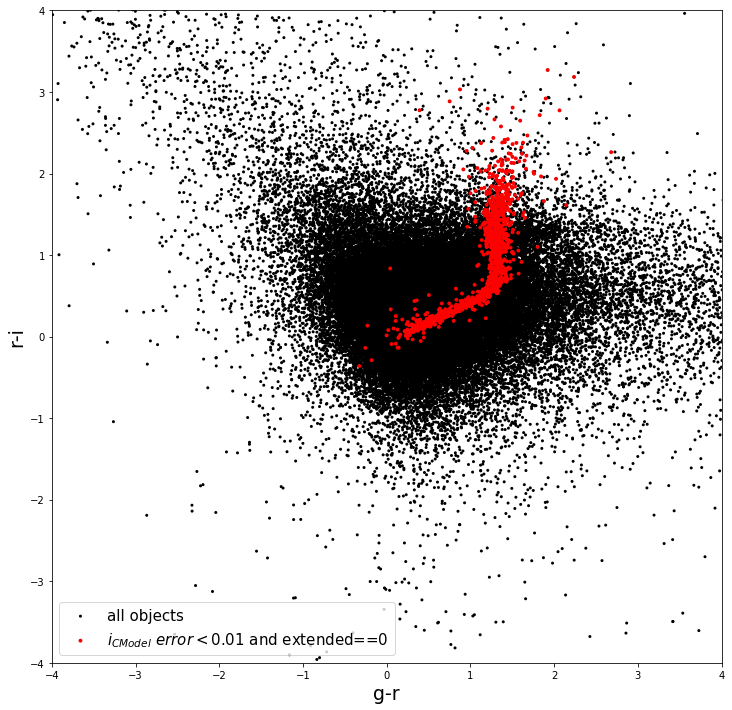

In [19]:
plt.scatter(grmod,rimod,marker='o',s=9,c='k',edgecolor='none',label = 'all objects')
plt.scatter(grmodcut,rimodcut,marker='o',s=15,c='r',edgecolor='none',label = '$i_{CModel}\ error<0.01$ and extended==0')
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend(loc='lower left',fontsize=15)


In [20]:
print (len(grmodcut))

1151


The stellar locus is clearly defined for bright non-extended objects.  There appears to be some width to the stellar locus, even for very small (i_err<0.01) selection shown here.  Are the magnitudes corrected for Galactic dust?  What else could be causing this slight broadening?

With slightly larger magnitude errors, looks like some unextended galaxies are present in addition to the stellar locus, check the extended flag against the difference between PSF and CModel mags to make sure we are doing things sensibly, just do in I-band for now

105614


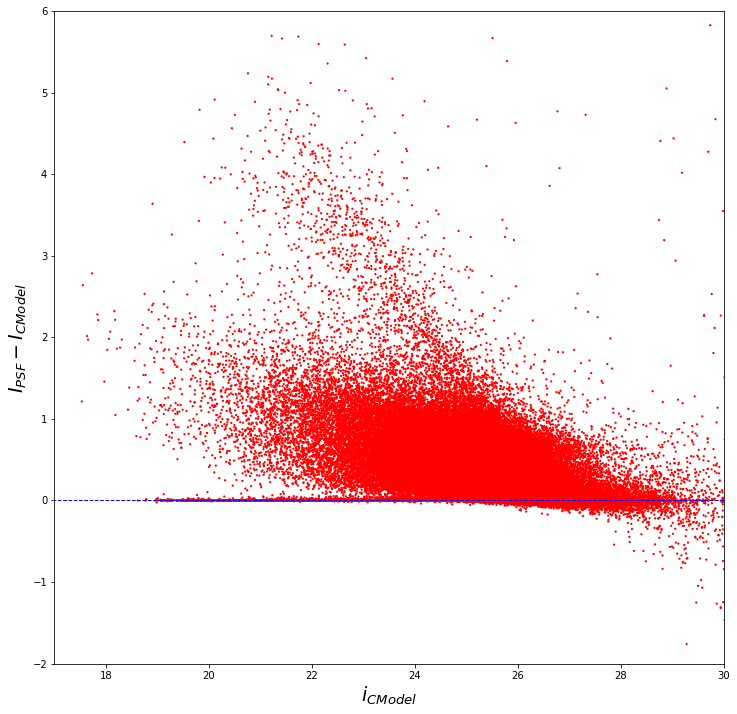

In [21]:
deli = df_hsc['I_psf']-df_hsc['I_cm']
extendedness = df_hsc['extended']
plt.scatter(df_hsc['I_cm'],deli,marker='o',s=5,c='r',edgecolor='none')
plt.plot([15,34],[0,0],linewidth=1,linestyle='--',color='b')
plt.xlabel("$i_{CModel}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CModel}$",fontsize=19)
plt.ylim([-2,6])
plt.xlim([17,30])
print (len(deli))

Zoom in a bit to match Fig 16 of Bosch et al 2017, draw the delta_mag = 0.0164 line for reference

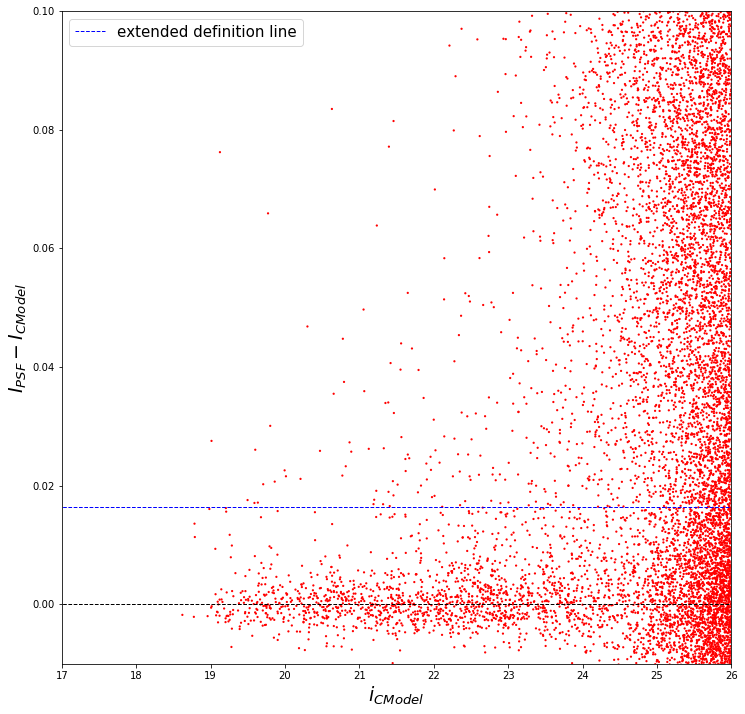

In [22]:
deli = df_hsc['I_psf']-df_hsc['I_cm']
extendedness = df_hsc['extended']
plt.scatter(df_hsc['I_cm'],deli,marker='o',s=5,c='r',edgecolor='none')
plt.plot([])
plt.plot([15,34],[0,0],linewidth=1,linestyle='--',color='k')
plt.plot([15,34],[0.0164,0.0164],linewidth=1,linestyle='--',color='b',label='extended definition line')
plt.xlabel("$i_{CModel}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CModel}$",fontsize=19)
plt.ylim([-.01,.1])
plt.xlim([17,26])
plt.legend(loc='upper left',fontsize=15)

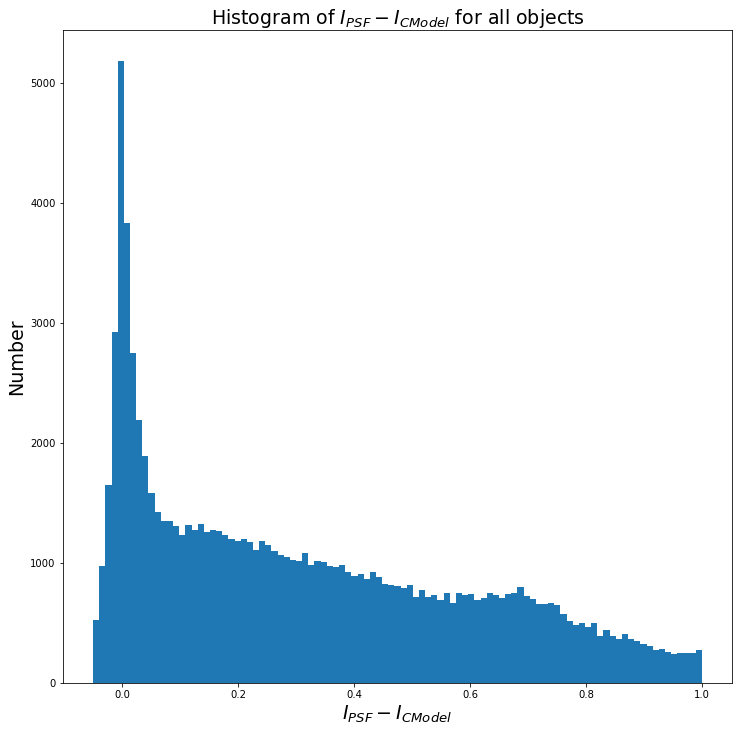

In [23]:
binedges = np.linspace(-.05,1.,100)
plt.hist(deli,bins=binedges,range=(-.05,1))
plt.xlabel('$I_{PSF}-I_{CModel}$',fontsize=19)
plt.ylabel('Number',fontsize=19)
plt.title("Histogram of $I_{PSF}-I_{CModel}$ for all objects",fontsize=19)

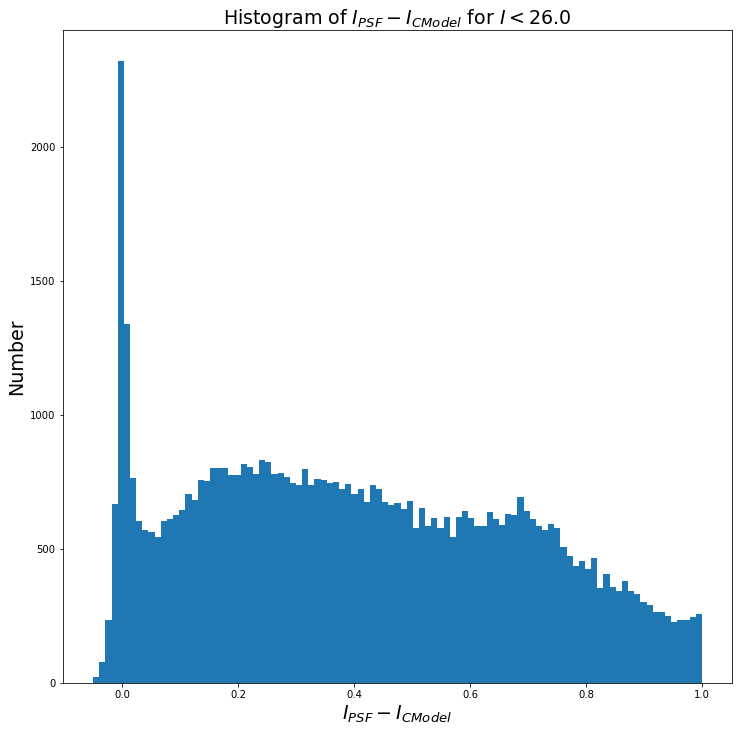

In [24]:
mask = (df_hsc['I_cm']<26.)
binedges = np.linspace(-.05,1.,100)
plt.hist(deli[mask],bins=binedges,range=(-.05,1))
plt.xlabel('$I_{PSF}-I_{CModel}$',fontsize=19)
plt.ylabel('Number',fontsize=19)
plt.title("Histogram of $I_{PSF}-I_{CModel}$ for $I<26.0$",fontsize=19)

plot extended ==0 and ==1 separately

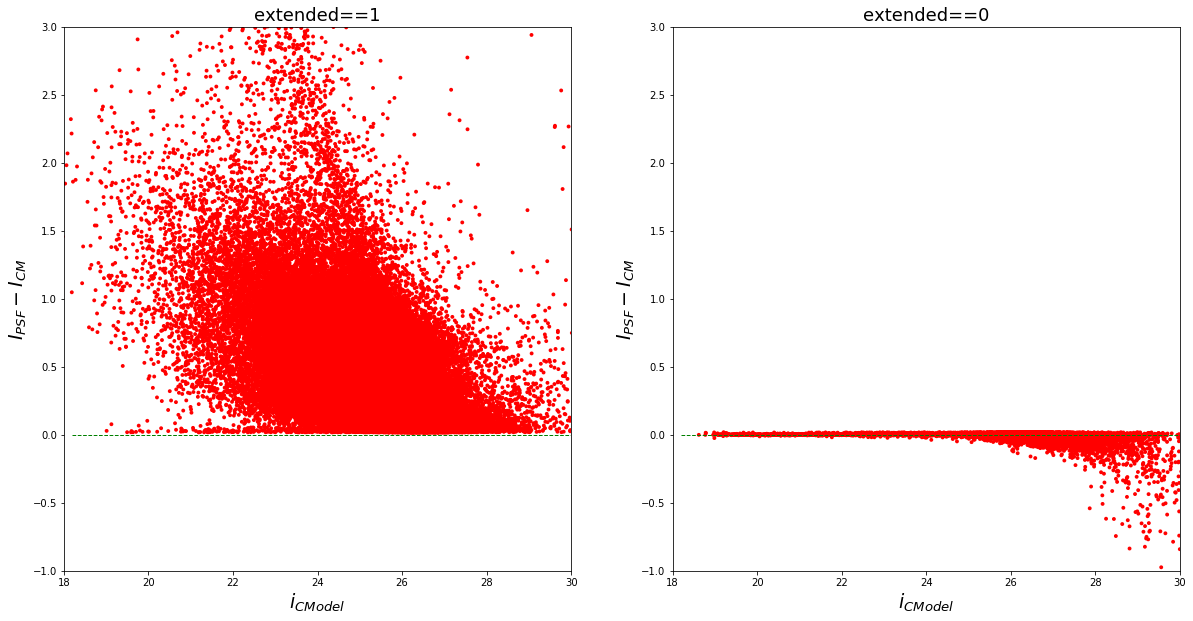

In [25]:
extflag = (extendedness>.4)
#psfcut = df_hsc['I_psf'][extflag]
#delicut = deli[extflag]
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(121)
ax.scatter(df_hsc['I_cm'][extflag],deli[extflag],marker='o',s=15,c='r',edgecolor='none')
#plt.scatter(psfcut,delicut,marker='o',s=5,c='b',edgecolor='None')
ax.plot([18.2,30],[0,0],linewidth=1,linestyle='--',color='g')
plt.xlabel("$i_{CModel}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)
plt.xlim([18,30])
plt.ylim([-1,3])
plt.title("extended==1", fontsize=18)
noextflag = np.invert(extflag)
bx = plt.subplot(122)
bx.scatter(df_hsc['I_cm'][noextflag],deli[noextflag],marker='o',s=15,c='r',edgecolor='none')
#plt.scatter(psfcut,delicut,marker='o',s=5,c='b',edgecolor='None')
bx.plot([18.2,30],[0,0],linewidth=1,linestyle='--',color='g')
plt.xlabel("$i_{CModel}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)
plt.xlim([18,30])
plt.ylim([-1,3])
plt.title("extended==0",fontsize=18)
#ax.scatter(deli,extendedness,marker='o',s=9,edgecolor='None',c='r')

Zoom in to show that the extendedness cut almost exactly matches the delta_mag = 0.0164 cut (modulo some small deviations, maybe due to roundoff errors when reading in/calculating magnitudes?)

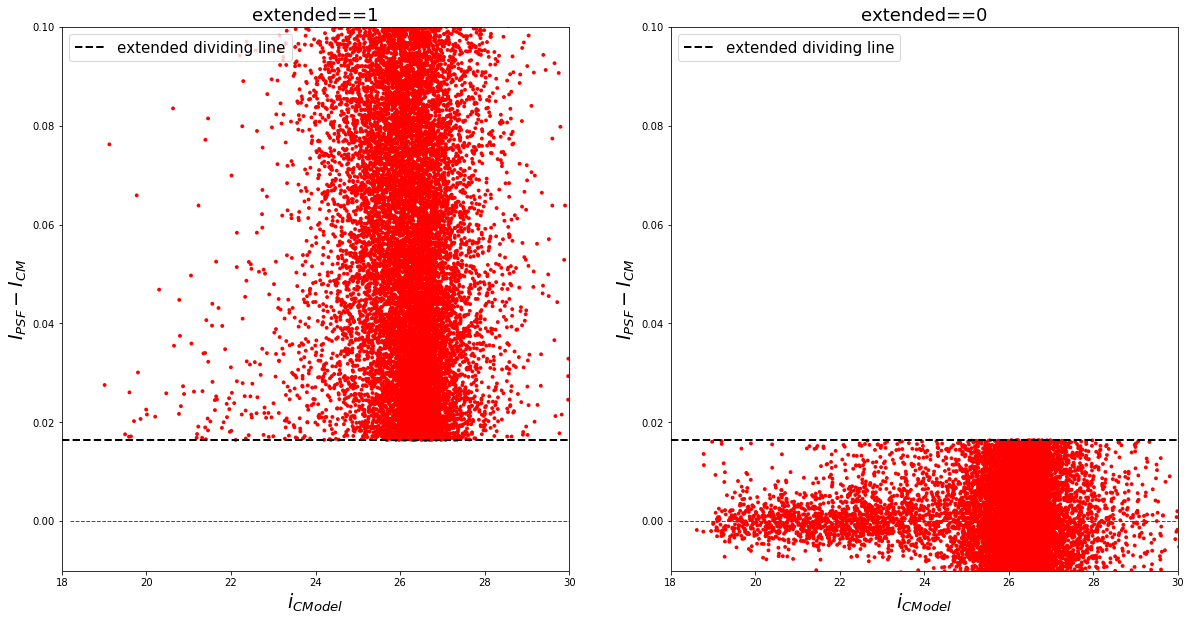

In [28]:
extflag = (extendedness>.4)
#psfcut = df_hsc['I_psf'][extflag]
#delicut = deli[extflag]
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(121)
ax.scatter(df_hsc['I_cm'][extflag],deli[extflag],marker='o',s=15,c='r',edgecolor='none')
ax.plot([18,30],[0.0164,0.0164],lw=2,linestyle='--',c='k',label="extended dividing line")
ax.plot([18.2,30],[0,0],linewidth=1,linestyle='--',color='g')
plt.xlabel("$i_{CModel}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)
plt.xlim([18,30])
plt.ylim([-.01,.1])
plt.title("extended==1", fontsize=18)
plt.legend(loc='upper left',fontsize=15)
noextflag = np.invert(extflag)
bx = plt.subplot(122)
bx.scatter(df_hsc['I_cm'][noextflag],deli[noextflag],marker='o',s=15,c='r',edgecolor='none')
#plt.scatter(psfcut,delicut,marker='o',s=5,c='b',edgecolor='None')
bx.plot([18.2,30],[0,0],linewidth=1,linestyle='--',color='g')
bx.plot([18,30],[0.0164,0.0164],lw=2,linestyle='--',c='k',label="extended dividing line")
plt.xlabel("$i_{CModel}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)
plt.xlim([18,30])
plt.ylim([-.01,.1])
plt.title("extended==0",fontsize=18)
plt.legend(loc='upper left',fontsize=15)
#ax.scatter(deli,extendedness,marker='o',s=9,edgecolor='None',c='r')

So, we've confirmed that the extended flag is functioning as expected.  Next step is to incorporate color information to improve this measure (we did not get that far in our one day of hacking).